In [1]:
cd ..

/home/max/Documents/mgr


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
class RelaxedEmbeddingLayer(nn.Module):
    def __init__(self, *, emb_size, n_concepts, n_roles):
        super().__init__()
        self.n_concepts = n_concepts
        self.n_roles = n_roles
        self.emb_size = emb_size
        self.top_concept = nn.Parameter(T.zeros((1, emb_size)))
        self.bot_concept = nn.Parameter(T.zeros((1, emb_size)))
        self.concepts = nn.Parameter(T.zeros((n_concepts, emb_size)))
        self.roles = nn.ModuleList([nn.Linear(emb_size, emb_size) for _ in range(n_roles)])
        self.and_nn = nn.Linear(2*emb_size + emb_size**2, emb_size)
        self.not_nn = nn.Linear(emb_size, emb_size)
        for x in [self.concepts, self.top_concept, self.bot_concept]:
            nn.init.xavier_normal_(x)
        
    @classmethod
    def from_onto(cls, onto, *args, **kwargs):
        return cls(n_concepts=onto.n_concepts, n_roles=onto.n_roles, *args, **kwargs)
    
class RelaxedReasonerHead(nn.Module):
    def __init__(self, *, emb_size, hidden_size):
        super().__init__()
        self.hidden_size, self.emb_size = hidden_size, emb_size
        self.sub_nn = nn.Sequential(
            nn.Linear(2*emb_size + emb_size**2, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, 1),
        )
        
        self.rvnn_act = lambda x: x
            
    def encode(self, axiom, embeddings):
        def rec(expr):
            if expr == TOP:
                return self.rvnn_act(embeddings.top_concept[0])
            elif expr == BOT:
                return self.rvnn_act(embeddings.bot_concept[0])
            elif isinstance(expr, int):
                return self.rvnn_act(embeddings.concepts[expr])
            elif expr[0] == SUB:
                c = rec(expr[1])
                d = rec(expr[2])
                cxd = T.outer(c, d).view(-1)
                return self.sub_nn(T.cat((c, d, cxd)))
            elif expr[0] == AND:
                c = rec(expr[1])
                d = rec(expr[2])
                return self.rvnn_act(embeddings.and_nn(im(c, d)))
            elif expr[0] == ANY:
                c = rec(expr[2])
                r = embeddings.roles[expr[1]]
                return self.rvnn_act(r(c))
            elif expr[0] == NOT:
                c = rec(expr[1])
                return self.rvnn_act(embeddings.not_nn(c))
            assert False, f'Unsupported expression {expr}. Did you convert it to core form?'
        return rec(axiom)
    
    def classify_batch(self, axioms, embeddings):
        return T.vstack([self.encode(axiom, emb) for axiom, emb in zip(axioms, embeddings)])
    
    def classify(self, axiom, emb):
        return self.classify_batch([axiom], [emb])[0].item()
    
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
lr_reasoner = 0.0001
lr_encoder = 0.0002
lr_encoder_test = lr_encoder
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = RelaxedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [RelaxedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 1953 parameters
created 40 encoders with 2610 parameters each
train epoch 00/15 | batch 2001/2000 | loss 0.7140 | val loss 0.7142 | acc 0.2399 | f1 0.3445 | prec 0.2110 | recall 0.9370 | roc auc 0.5208 | pr auc 0.2402 | elapsed 14.65s
train epoch 01/15 | batch 2001/2000 | loss 0.5932 | val loss 0.5106 | acc 0.7887 | f1 0.0265 | prec 0.7302 | recall 0.0135 | roc auc 0.5906 | pr auc 0.3173 | elapsed 60.03s
train epoch 02/15 | batch 2001/2000 | loss 0.4815 | val loss 0.4508 | acc 0.8095 | f1 0.2083 | prec 0.9114 | recall 0.1176 | roc auc 0.7368 | pr auc 0.5232 | elapsed 59.89s
train epoch 03/15 | batch 2001/2000 | loss 0.3977 | val loss 0.3893 | acc 0.8454 | f1 0.4853 | prec 0.8358 | recall 0.3419 | roc auc 0.8128 | pr auc 0.6534 | elapsed 58.11s
train epoch 04/15 | batch 2001/2000 | loss 0.3164 | val loss 0.3443 | acc 0.8728 | f1 0.6305 | prec 0.8271 | recall 0.5094 | roc auc 0.8532 | pr auc 0.7356 | elapsed 57.66s
train epoch 05/15 | batch 2001/2000 | loss 0.2569 |

In [4]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = RelaxedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner), ('random reasoner', random_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [RelaxedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.5331 | val loss 1.5331 | acc 0.5116 | f1 0.3131 | prec 0.2255 | recall 0.5120 | roc auc 0.5097 | pr auc 0.2289 | elapsed 10.76s
train epoch 01/10 | batch 1251/1250 | loss 0.9915 | val loss 0.6901 | acc 0.7144 | f1 0.3131 | prec 0.3280 | recall 0.2994 | roc auc 0.6203 | pr auc 0.3023 | elapsed 28.17s
train epoch 02/10 | batch 1251/1250 | loss 0.6346 | val loss 0.5539 | acc 0.7728 | f1 0.3849 | prec 0.4678 | recall 0.3269 | roc auc 0.7112 | pr auc 0.4165 | elapsed 28.24s
train epoch 03/10 | batch 1251/1250 | loss 0.5201 | val loss 0.4563 | acc 0.8153 | f1 0.4834 | prec 0.6166 | recall 0.3975 | roc auc 0.7875 | pr auc 0.5542 | elapsed 28.24s
train epoch 04/10 | batch 1251/1250 | loss 0.4288 | val loss 0.3746 | acc 0.8545 | f1 0.5989 | prec 0.7475 | recall 0.4997 | roc auc 0.8518 | pr auc 0.6914 | elapsed 28.33s
train epoch 05/10 | batch 1251/1250 | loss 0.3525 | val loss 0.3043 | acc 0.8881 | f1 0.7007 | prec 0.8378 | recall 0.

In [5]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20220715T194328


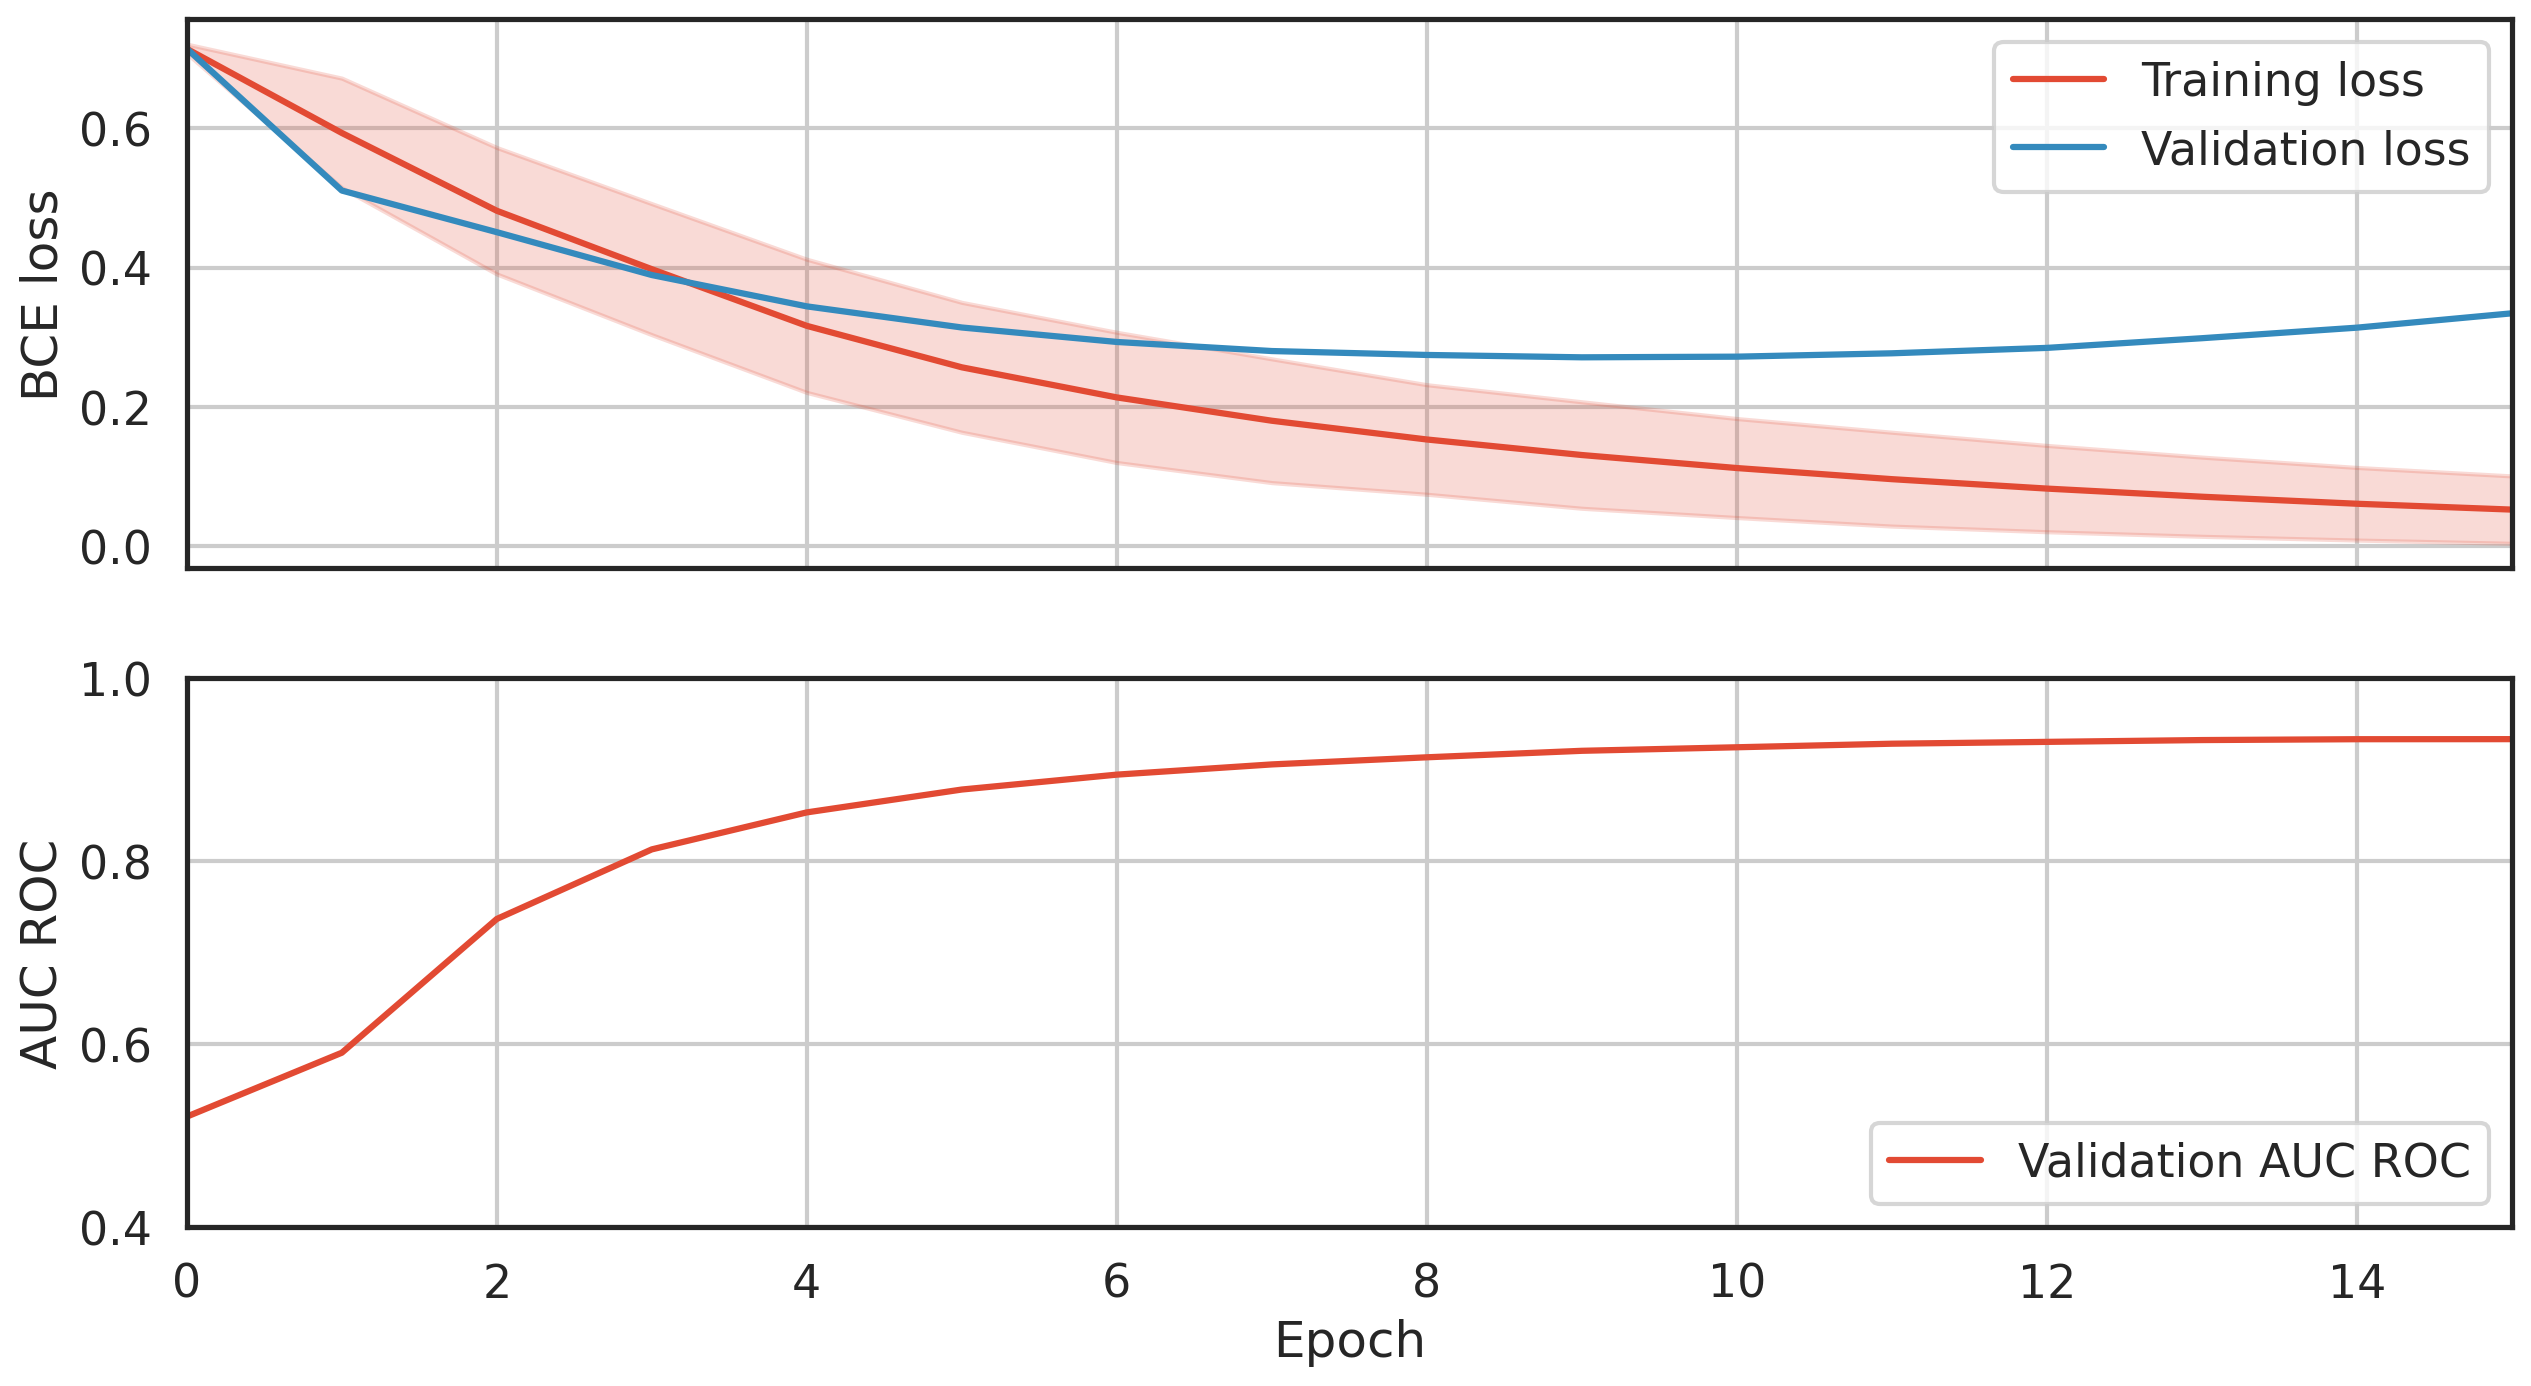

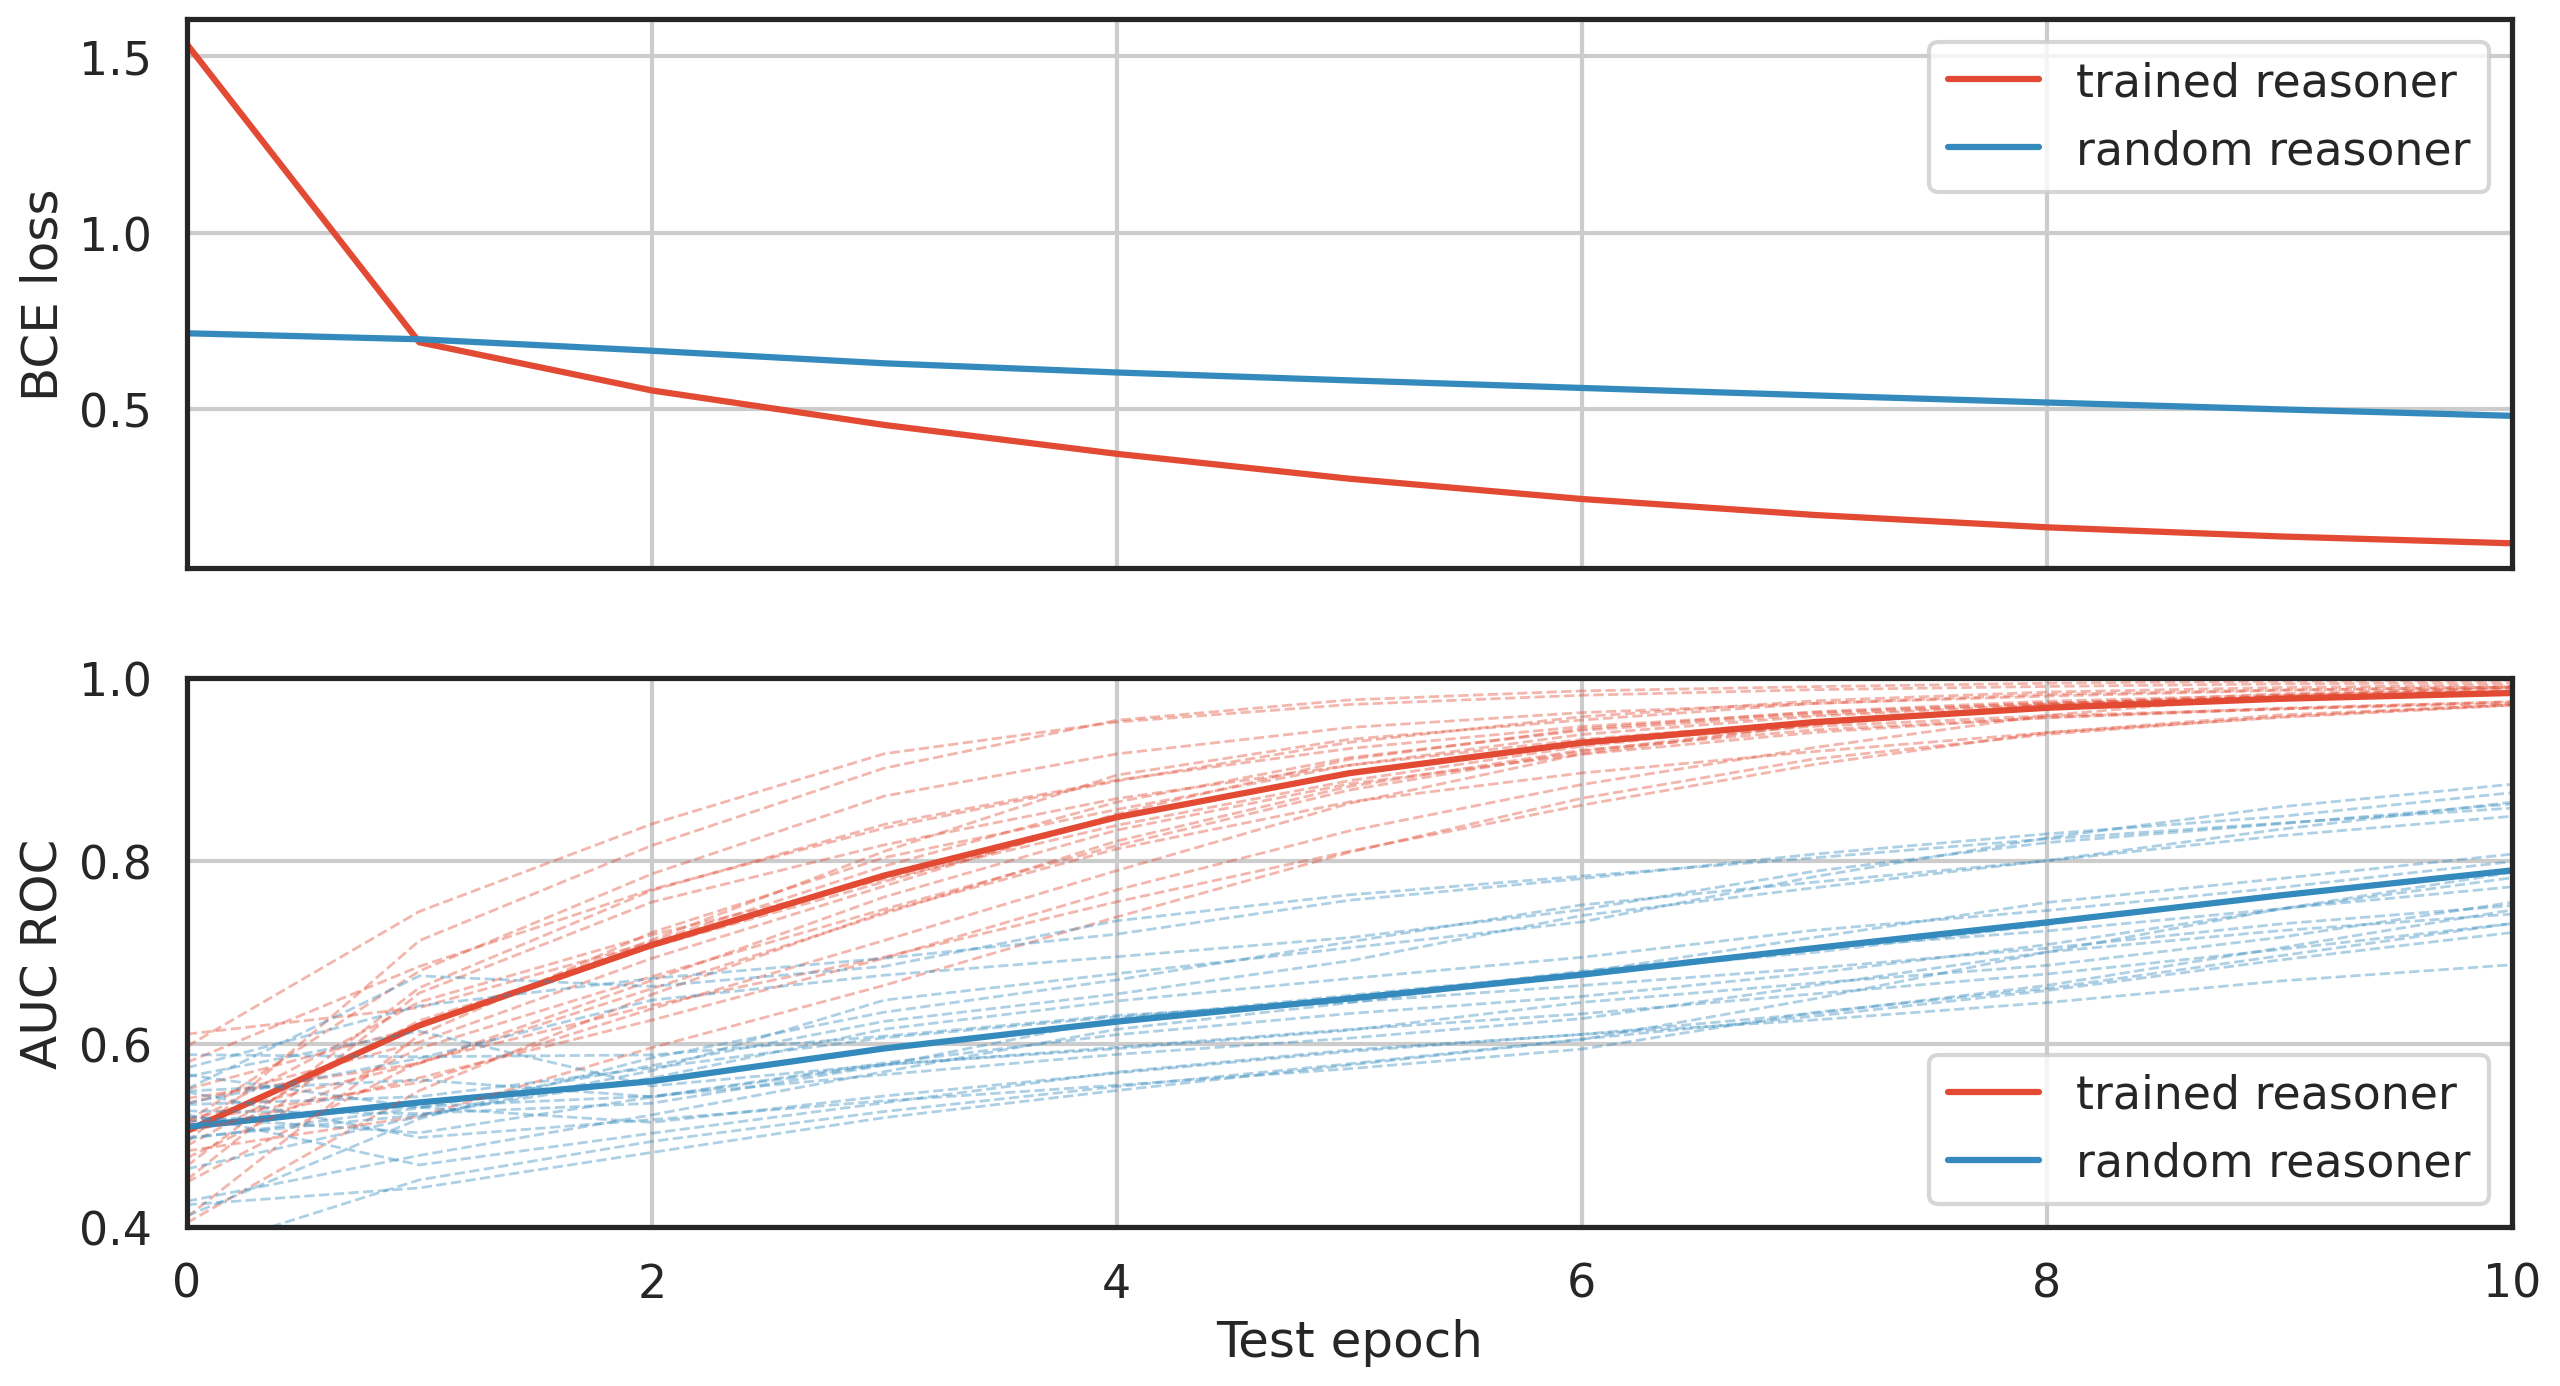

             mean       std     micro
acc      0.958575  0.013878  0.958575
prec     0.971351  0.019688  0.970710
recall   0.833240  0.048836  0.834637
f1       0.896480  0.034080  0.897545
auc_roc  0.983654  0.008629  0.984794
auc_pr   0.963623  0.017681  0.965730
             mean       std     micro
acc      0.775575  0.046395  0.775575
prec     0.490122  0.100695  0.485864
recall   0.549465  0.136375  0.555313
f1       0.510760  0.096528  0.518272
auc_roc  0.789843  0.058338  0.790860
auc_pr   0.635227  0.116768  0.643010


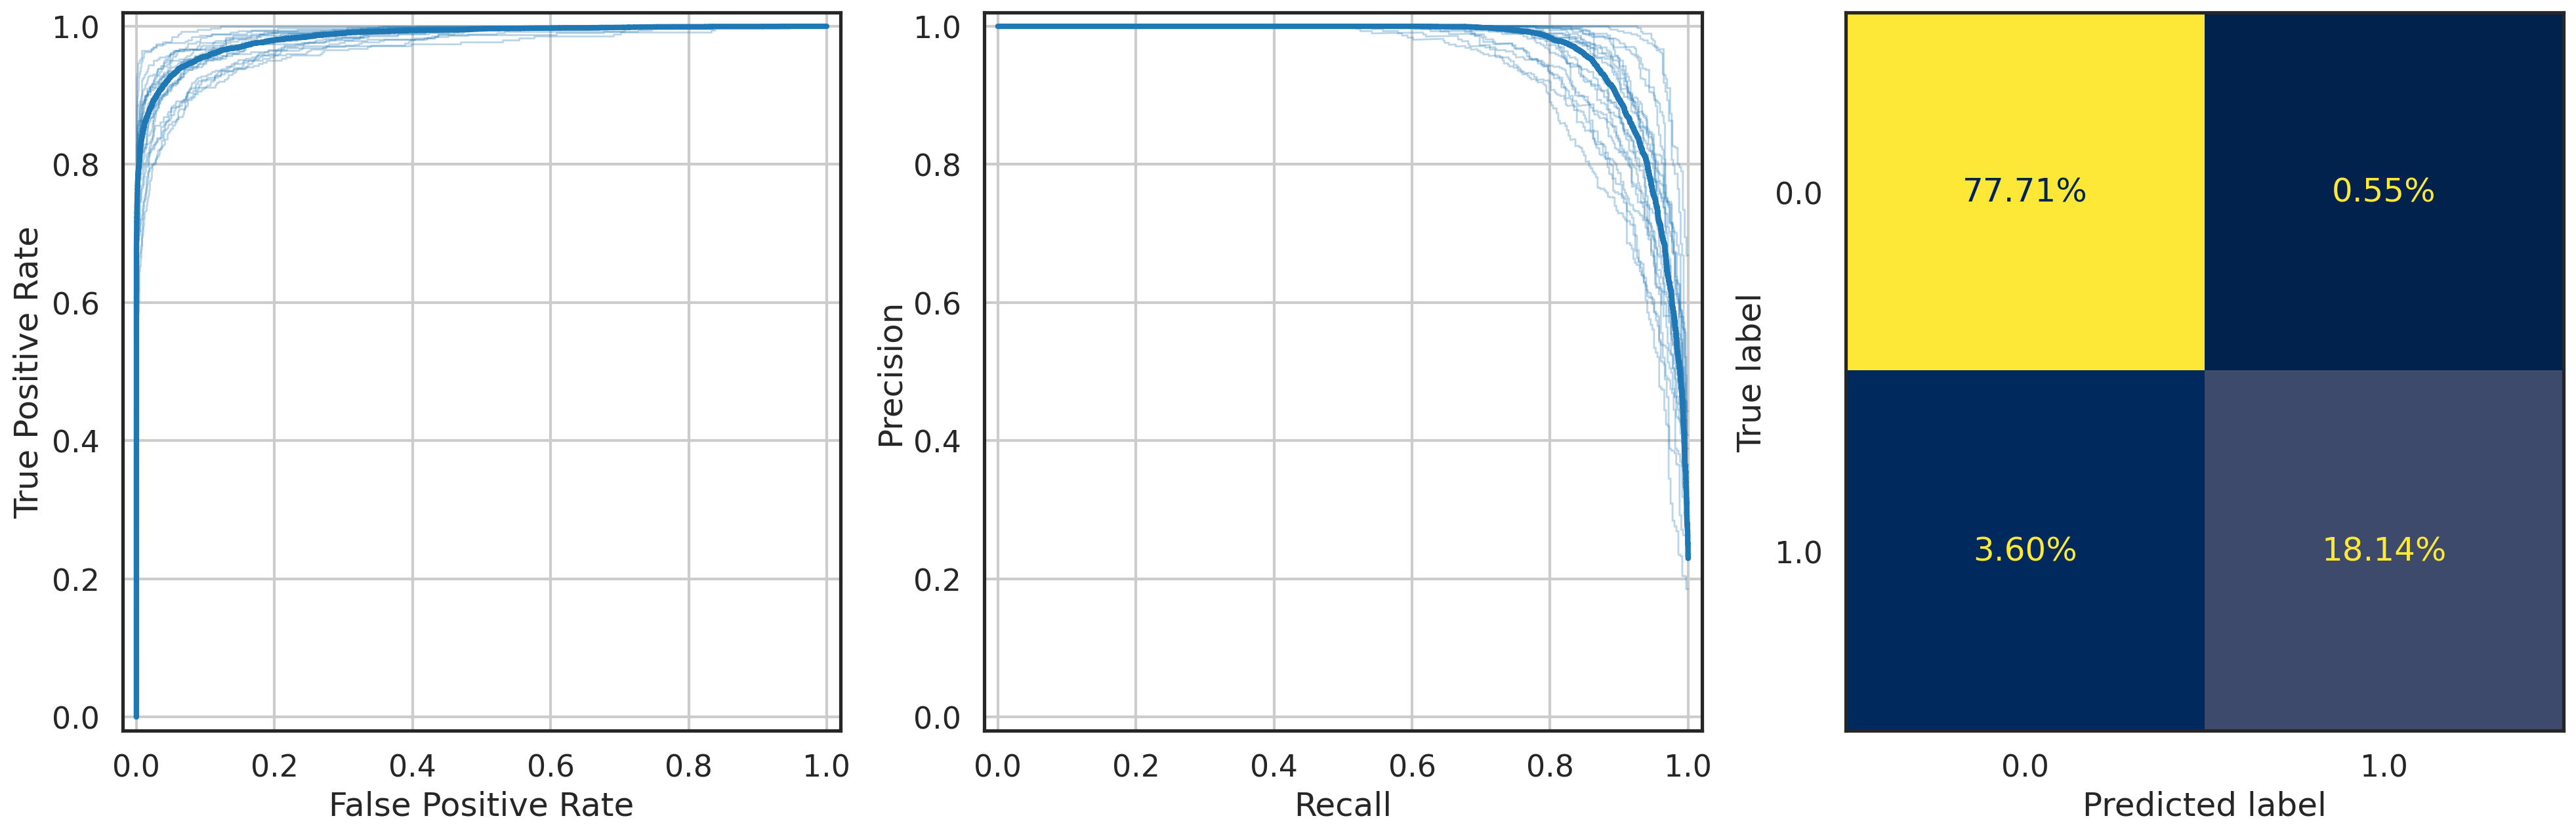

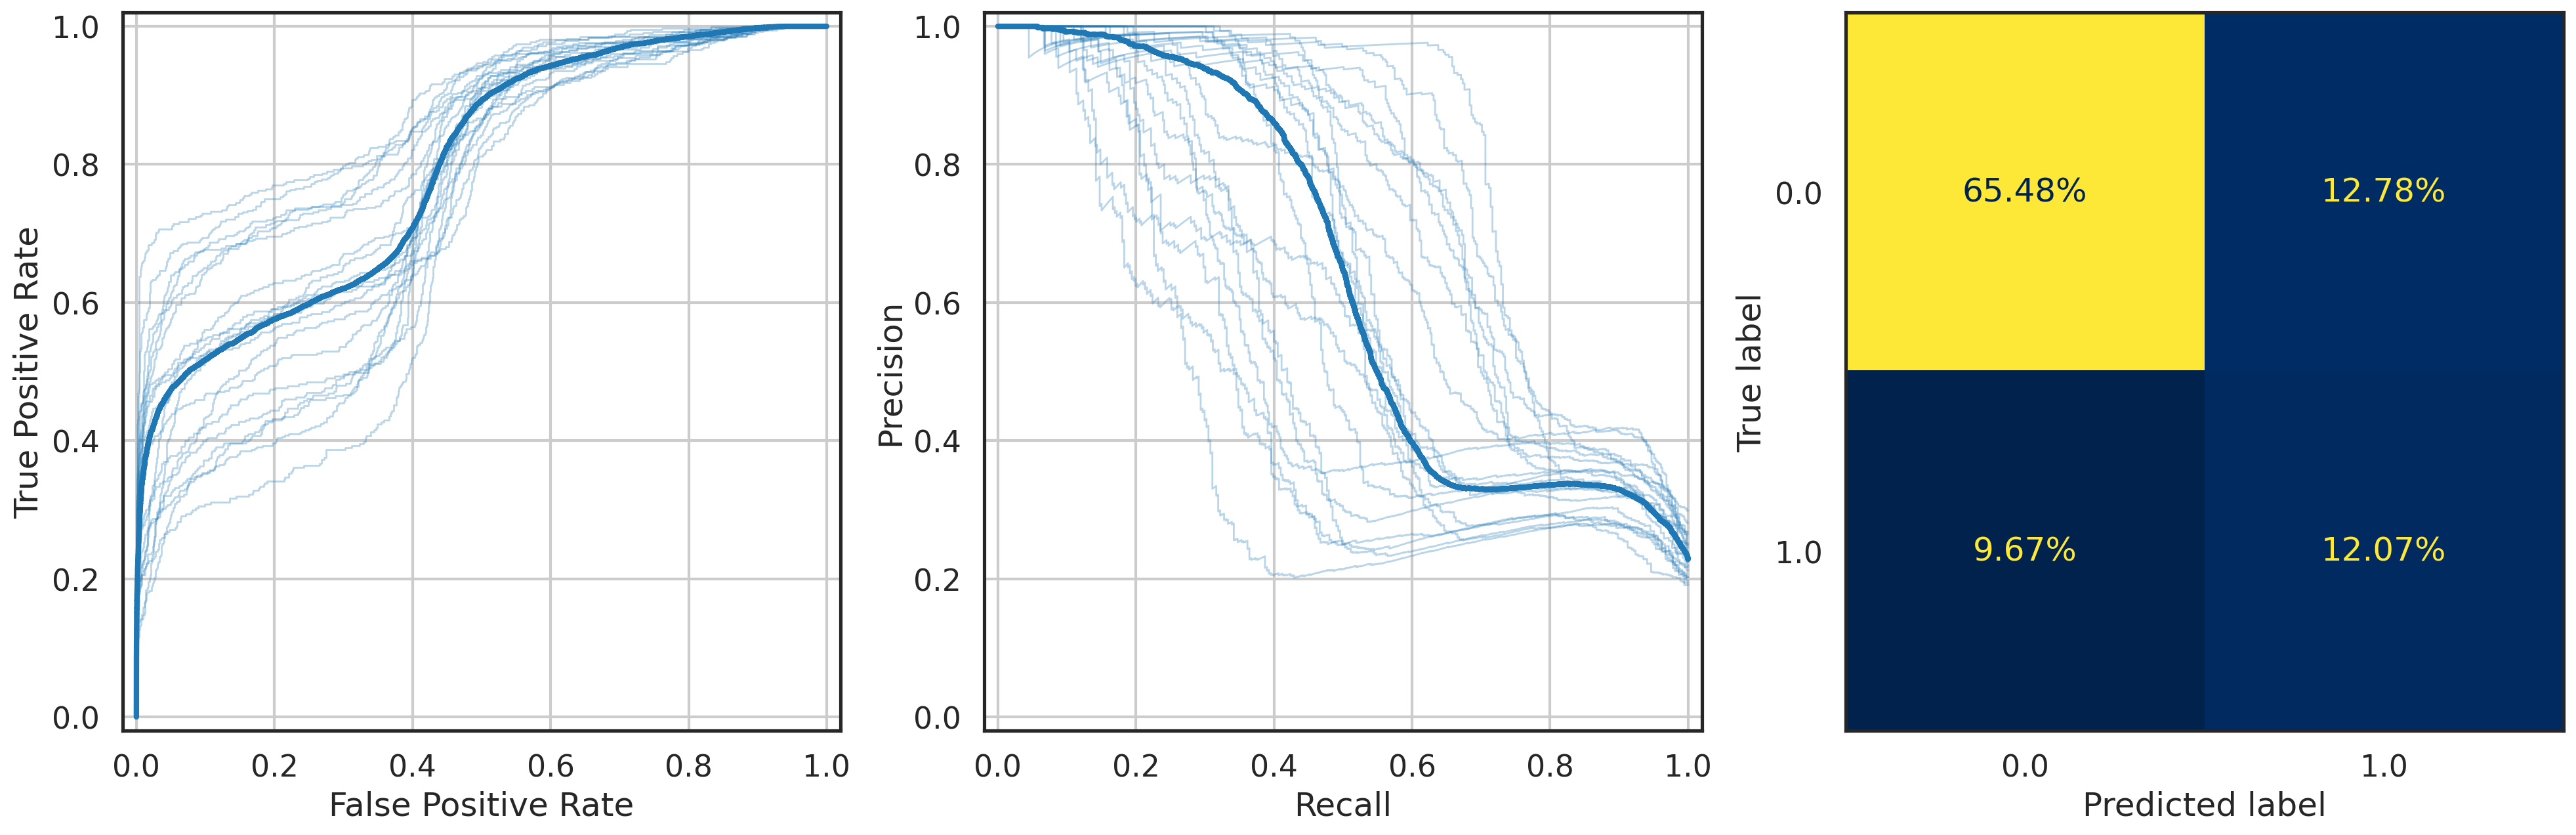

In [6]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good, Y_te_rand=Y_te_rand))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto, save=base+'/test.png')
print(report(test_onto, y_te, np.array(Y_te_good), idx_te, save=base+'/%-trained'))
print(report(test_onto, y_te, np.array(Y_te_rand), idx_te, save=base+'/%-random'))